<div style="text-align: center;">
    <span style="font-size: 48px; color: darkred; text-decoration: underline;"><strong>XGBoost</strong></span>
</div>


In [1]:
#Importation des Packages nécessaires
import pandas as pd
import numpy as np
import plotly.express
import plotly.graph_objects as go
import matplotlib.pyplot as  plt
import shap
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import log_loss, precision_score, recall_score, f1_score, accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

import random

c:\Users\alexi\Desktop\Projet_Scoring_1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import des données brutes pour comparaison
data_score_raw = pd.read_csv("data/hmeq.csv")

# Création des ensembles de train et test sur les données brutes
data_train_raw, data_test_raw = train_test_split(data_score_raw,
                                                 test_size=0.3,random_state=99,stratify=data_score_raw['BAD'])

Afin de voir l'impact de notre EDA sur le modèle XGBoost, nous allons comparer les résultats sur la base de données nettoyée et sur la base de données brute.



In [3]:
# Import des données nettoyées, définition des Features et des variables cibles

data_train = pd.read_csv("data/data_train.csv")
data_test = pd.read_csv("data/data_test.csv")

y_test = data_test['BAD']
y_train = data_train['BAD']

col_with_med = ['LOAN', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
     'NINQ', 'CLNO','DEBTINC',
     'REASON_HomeImp', 'JOB_Office', 'JOB_Other',
     'JOB_ProfExe', 'JOB_Sales', 'JOB_Self']

raw_col = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
     'NINQ', 'CLNO', 'DEBTINC']

# Train nettoyé
x_train_med = data_train[col_with_med]

# Test nettoyé
x_test_med = data_test[col_with_med]

# Train données brutes
x_train_raw = data_train_raw[raw_col]
y_train_raw = data_train_raw['BAD']

# Test données brutes
x_test_raw = data_test_raw[raw_col]
y_test_raw = data_test_raw['BAD']

# Pour lancer XGBoost, il est préférable de transformer les données en DMatrix
# qui est un format adapté pour ce package. Les algorithmes sont plus performants
# et convergent plus rapidement si les inputs sont sous ce format.

data_dmatrix_train_med = xgb.DMatrix(data=x_train_med,label=y_train)
data_dmatrix_test_med = xgb.DMatrix(data=x_test_med,label=y_test)

data_dmatrix_train_raw = xgb.DMatrix(data=x_train_raw,label=y_train_raw)
data_dmatrix_test_raw = xgb.DMatrix(data=x_test_raw,label=y_test_raw)

<span style="font-size: 24px; color: darkred; text-decoration: underline;"><strong>XGBoost simple</strong></span>

In [4]:
# Indiquons quelqules paramètres afin de lancer un modèle en premier lieu non
# optimisé

params = {
            'objective':'binary:logistic', # On veut prédire une valeur binaire
            'max_depth': 1, #  Commencons avec des arbres simples
            'alpha': 10,
            'learning_rate': 1.0
        }

# Entrainement des modèles

xgb_clf_med = xgb.train(params, dtrain= data_dmatrix_train_med)
xgb_clf_raw = xgb.train(params, dtrain= data_dmatrix_train_raw)

In [5]:
# La fonction predict nous donne la probabilité de chaque individus d'appartenir
# à la classe 1
y_pred_med_probs = xgb_clf_med.predict(data_dmatrix_test_med)

# Si l'on veut obtenir un résultat binaire, on peut ainsi arrondir les probabilités
y_pred_med = [round(p) for p in y_pred_med_probs]

y_pred_raw_probs = xgb_clf_raw.predict(data_dmatrix_test_raw)
y_pred_raw = [round(p) for p in y_pred_raw_probs]

print(f"Le F1 Score de notre XGBoost utilisant l'imputation par médiane est : {round(f1_score(y_test, y_pred_med),2)}")
print(f"Le F1 Score de notre XGBoost utilisant les données brutes est : {round(f1_score(y_test_raw, y_pred_raw),2)}")

Le F1 Score de notre XGBoost utilisant l'imputation par médiane est : 0.61
Le F1 Score de notre XGBoost utilisant les données brutes est : 0.68


In [6]:
results = [y_pred_med, y_pred_raw]
test_type = [y_test, y_test_raw]

prediction_type = ['Modèle Complet', 'Données Brutes']
for i, pred_type in enumerate(results):
    cr = classification_report(test_type[i], pred_type)
    print(f"\nTableau des métriques pour la régression {prediction_type[i]} \n \n : {cr}")


Tableau des métriques pour la régression Modèle Complet 
 
 :               precision    recall  f1-score   support

           0       0.88      0.97      0.93      1431
           1       0.82      0.49      0.61       357

    accuracy                           0.88      1788
   macro avg       0.85      0.73      0.77      1788
weighted avg       0.87      0.88      0.86      1788


Tableau des métriques pour la régression Données Brutes 
 
 :               precision    recall  f1-score   support

           0       0.91      0.96      0.93      1431
           1       0.77      0.60      0.68       357

    accuracy                           0.89      1788
   macro avg       0.84      0.78      0.80      1788
weighted avg       0.88      0.89      0.88      1788



<span style="font-size: 24px; color: darkred; text-decoration: underline;"><strong>Réalisation des courbes ROC
</strong></span>

In [7]:
# On commence par créer un modèle naïf prédisant toujours une proabilité de 0%
# d'appartenir à la classe 1. Autrement dit il prédit toujours la classe 0.
ns_probs = [0 for _ in range(len(y_test))]

# Calcul des scores AUC
# Entre les données de tests et les probabilité de chaque modèle
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc_med = roc_auc_score(y_test, y_pred_med_probs)
lr_auc_raw = roc_auc_score(y_test_raw, y_pred_raw_probs)

print(f'Naïf: ROC AUC = {np.round(ns_auc,2)}')
print(f'XGBoost | Médiane: ROC AUC = {np.round(lr_auc_med,2)}')
print(f'XGBoost | Raw : ROC AUC = {np.round(lr_auc_raw,2)}')

# Calcul des courbes ROC via les taux de faux positifs et de vrai positifs
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr_med, lr_tpr_med, _ = roc_curve(y_test, y_pred_med_probs)
lr_fpr_raw, lr_tpr_raw, _ = roc_curve(y_test_raw, y_pred_raw_probs)

fig = go.Figure()

fig.add_trace(go.Scatter(x=ns_fpr, y=ns_tpr, mode='lines',
                         name='Modèle Naïf',
                         ))

fig.add_trace(go.Scatter(x=lr_fpr_med, y=lr_tpr_med, mode='lines',
                         name='XGBoost | Modèle Simple',
                         ))

fig.add_trace(go.Scatter(x=lr_fpr_raw, y=lr_tpr_raw, mode='lines',
                         name='XGBoost | Modèle Brute',
                         ))

fig.update_layout(
    title="Courbes ROC",
    xaxis_title="Taux de Faux Positifs",
    yaxis_title="Taux de Vrais Positifs",
    legend_title="Modèles",
    template="plotly_white"
)
fig.show()

Naïf: ROC AUC = 0.5
XGBoost | Médiane: ROC AUC = 0.88
XGBoost | Raw : ROC AUC = 0.89


Premièrement on observe que les modèles XGBoost développés font mieux que le hasard. En effet, leurs AUC est > 0.5 et visuellement les courbes sont au-deçu de celle du modèle naïf.

Deuxièmement, on s'apercoit que les différences entre le modèle sur les données brutes et sur les données issues de l'EDA ne sont pas très grandes indiquant que le modèle performe sensiblement aussi bien sur l'un que sur l'autre. Cela peut s'expliquer par le fait que XGBoost est un modèle préparé à travailler sur des données non optimisées et il gère ainsi bien les données manquantes et outliers par exemple.

On effectue ensuite un Grid Search ainsi qu'une Cross Validation afin d'estimer de manière plus précise les performance de notre modèle sur différentes observations et dans le même temps de l'opitmiser.

In [8]:
# Sélection des hyper-paramètres du Grid Search
params_grid = {
    'learning_rate': [0.01, 0.05],
    'gamma':[0, 0.01],
    'max_depth': [6, 7],
    'min_child_weight': [1, 2],
    'subsample': [0.6, 0.7,],
    'n_estimators': [400, 600],
    'colsample_bytree':[0.7, 0.8],
}

stratified_kfold = StratifiedKFold(n_splits=4)

classifier = XGBClassifier()

grid_classifier = GridSearchCV(
    estimator=classifier,
    param_grid=params_grid,
    scoring='roc_auc',
    cv=stratified_kfold # Utilisation du Stratified K-Fold comme méthode de Cross Validation
    # Afin de s'assurer que chaque segment créée dispose bien des mêmes proportions de
    # la variable cible.
)
grid_classifier.fit(x_train_med, y_train)

c:\Users\alexi\Desktop\Projet_Scoring_1\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning:

invalid value encountered in cast



GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.7, 0.8], 'gamma': [0, 0.01],
                         'learning_rate': [0.01, 0.05], 'max_depth': [6, 7],
                         'min_child_weight': [1, 2], 'n_estimators': [400, 600],
                         'subsample': [0.6, 0.7]},
             scoring='roc_auc')

In [9]:
# On récupère les meilleurs hyper-paramètres du modèle
best_parameters = grid_classifier.best_params_
best_parameters

{'colsample_bytree': 0.7,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 600,
 'subsample': 0.7}

<span style="font-size: 24px; color: darkred; text-decoration: underline;"><strong>Courbes ROC du modèle avant et après optimisation</strong></span>

In [10]:
# La fonction suivante nous donne les probabilité prédites du modèle que chaque observation
# appartienne soit à la classe 0 soit à la classe 1
grid_test_preds_probs = grid_classifier.predict_proba(x_test_med)[:, 1] # On ne sélectionne
# ici que la probabilité d'appartenir à la classe 1.


# AUC du meilleur modèle, on lui fournit les probabilités prédites
grid_test_roc_auc = roc_auc_score(y_test, grid_test_preds_probs)

# Regardons visuellement la différence avant et après le GridSerchCV
best_model = grid_classifier.best_estimator_

print(f'Naïf: ROC AUC = {round(ns_auc,2)}')
print(f'XGBoost | Données Brutes: ROC AUC = {round(lr_auc_raw,2)}')
print(f'XGBoost | Avant GridSearch: ROC AUC = {round(lr_auc_med,2)}')
print(f'XGBoost | Après GridSearch: ROC AUC = {round(grid_test_roc_auc,2)}')

# Calcul des courbes ROC
lr_fpr_best, lr_tpr_best, thresholds = roc_curve(y_test, grid_test_preds_probs)

# Recherche du meilleur seuil de séparation via la différence entre le TPR et le FPR
tpr_fpr_diff = lr_tpr_best - lr_fpr_best

best_idx = np.argmax(tpr_fpr_diff)
best_threshold = thresholds[best_idx]
best_tpr = lr_tpr_best[best_idx]
best_fpr = lr_fpr_best[best_idx]

fig = go.Figure()

fig.add_trace(go.Scatter(x=ns_fpr, y=ns_tpr, mode='lines',
                         name='No Skill',
                         ))

fig.add_trace(go.Scatter(x=lr_fpr_best, y=lr_tpr_best, mode='lines',
                         name='XGBoost | Après GridSearch',
                         ))

fig.add_trace(go.Scatter(x=lr_fpr_med, y=lr_tpr_med, mode='lines',
                         name='XGBoost | Avant GridSearch',
                         ))

fig.add_trace(go.Scatter(x=lr_fpr_raw, y=lr_tpr_raw, mode='lines',
                         name='XGBoost | Données Brutes',
                         ))

fig.add_trace(go.Scatter(
    x=[best_fpr],
    y=[best_tpr],
    mode='markers+text',
    name='Meilleur Seuil',
    marker=dict(color='black', size=10),
    text=[f'Threshold: {best_threshold:.2f}<br>TPR: {best_tpr:.2f}<br>FPR: {best_fpr:.2f}'],
    textposition='bottom center'
))

# Paramètres du graphique
fig.update_layout(
    title="Courbe ROC Avant et Après GridSearch",
    xaxis_title="Taux de Faux Positifs (FPR)",
    yaxis_title="Taux de Vrais Positifs (TPR)",
    legend_title="Modèles",
    template="plotly_white",
    width=1000,  # Largeur du graphique
    height=600,  # Hauteur du graphique
)

fig.show()

Naïf: ROC AUC = 0.5
XGBoost | Données Brutes: ROC AUC = 0.89
XGBoost | Avant GridSearch: ROC AUC = 0.88
XGBoost | Après GridSearch: ROC AUC = 0.96


On voit ici l'impact du GridSearchCV sur la performance de notre modèle. La courbe s'est décalée vers la gauche indiquant un plus faible taux de Faux Positifs et un plus fort taux de vrai positifs. L'AUC est également impacté, passant de 0.88 à 0.96 avant et après le GridSearchCV

In [11]:
# On test la performance du modèle avec les meilleurs hyperparamètres
grid_test_preds = (grid_test_preds_probs >= best_threshold).astype(int)

# Accuracy du meilleur modèle, on lui fournit les classes prédites
grid_test_f1_score = f1_score(y_test, grid_test_preds)

print(f"Le F1-score du modèle optimisé est le suivant : {round(grid_test_f1_score,2)} et son AUC est de : {round(grid_test_roc_auc,2)}")

Le F1-score du modèle optimisé est le suivant : 0.79 et son AUC est de : 0.96


In [12]:
# Nous vérifions la log-loss sur le train et le test afin de vérifier un potentiel surraprentissage
# En effet, si une différence trop grande est observée et que l'erreur du test est supérieur, cela veut
# dire que le modèle ne parviens à suffisemment généralisé, ce qui peut-être un signe d'Overfitting

grid_train_preds = grid_classifier.predict(x_train_med)
grid_train_preds_probs = grid_classifier.predict_proba(x_train_med)[:, 1]

train_log_loss = log_loss(y_train, grid_train_preds_probs)
test_log_loss = log_loss(y_test, grid_test_preds_probs)

print(f"Train Log Loss: {train_log_loss:.2f}")
print(f"Test Log Loss: {test_log_loss:.2f}\n")

Train Log Loss: 0.03
Test Log Loss: 0.21



Ici, l'erreur moyenne sur notre échantillon train est très faible, indiquant que le modèle a bien appris sur les donénes Train. 
En revanche, même si l'erreur reste convenable sur l'ensemble de Test, elle est tout de même élevée et bien supérieur à celle de Train, indiquant un potentiel Overfitting du modèle.

<span style="font-size: 24px; color: darkred; text-decoration: underline;"><strong>Matrice de confusion du modèle optimisé</strong></span>

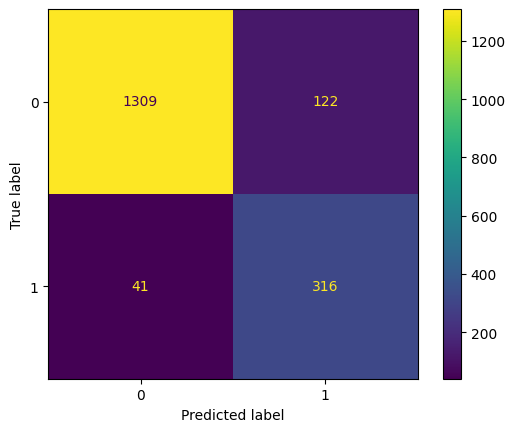

In [13]:
# On observe la matrice de confusion de ce modèle
cm = confusion_matrix(y_test, grid_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_classifier.classes_)
disp.plot()
plt.show()

XGBoost dispose d'une fonction "plot_importance" qui indique selon le type de critère choisie, l'importance des variables dans le modèle. Ici, le type 'weight' indique que l'on choisi d'utiliser le nombre de fois où la variable à été sélectionnée pour faire les splits dans les arbres. Plus une variable a été sélectionnée plus elle a d'importance dans la prédiction du modèle car elle divise au mieux les données

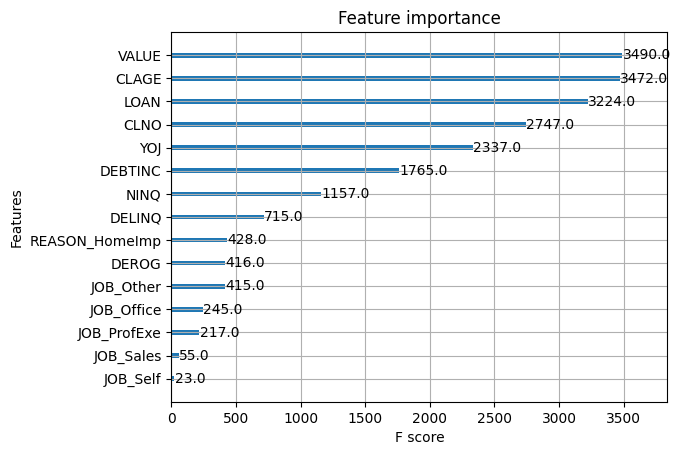

In [14]:
xgb.plot_importance(grid_classifier.best_estimator_, importance_type = 'weight')
plt.rcParams['figure.figsize'] = [6, 5]
plt.show()

D'après les résultats du graphique, on peut en conlcure que les variables les plus importantes pour notre modèle optimisé sont :  VALUE CLAGE LOAN CLNO YOJ DEBTINC...
De l'autre côté, les variables les moins porteuses d'informations sont : JOB_SELF JOB_SALES JOB_ProfExe, JOB_OFFICE...

Enfin, pour compléter notre analyse quant à la pertinence et l'importance de chaque variable dans le modèle, nous utilisons les valeurs de Shapley.

Les valeurs de SHapley sont des coefficients attribuées à chaque variables indiquant à quel point elles ont un impact sur la probabiltié prédites du modèle et aussi le sens de cet impact. Ainsi plus une variable a un impact fort, plus elle a de l'importance dans le modèle car sa présence influe fortement sur la prédiction.

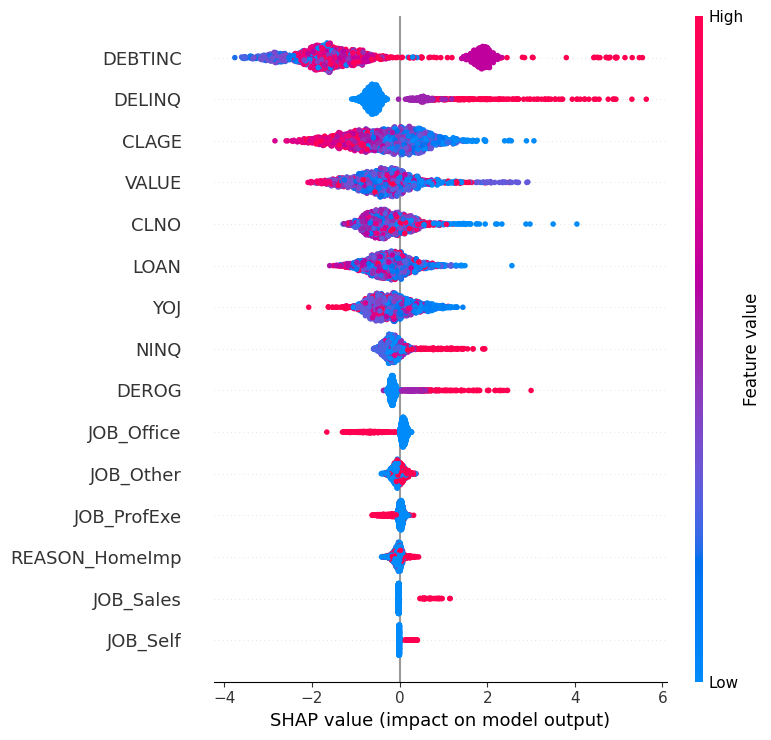

In [15]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(x_test_med)
shap.summary_plot(shap_values, x_test_med)

On voit ici que plus la valeur de DEBTINC, autrement dit plus le rapport
entre le salaire et l'endettement est grand, plus la probabilité pour que la
personne soit en défaut est élévée.
De même pour DEROG, plus le nombre de rapport dérogatoire est grand, plus la
probabilité prédite par le modèle va tendre vers 1, autrement dit, que la personne
soit en défaut.

En revanche, LOAN et CLAGE on des conclusions différentes indiquant
que plus la valeur de la maison sous-jacente est grande et plus le
1er crédit réalisé est ancien, alors plus la probabilité de ne pas
être en défaut est grande.

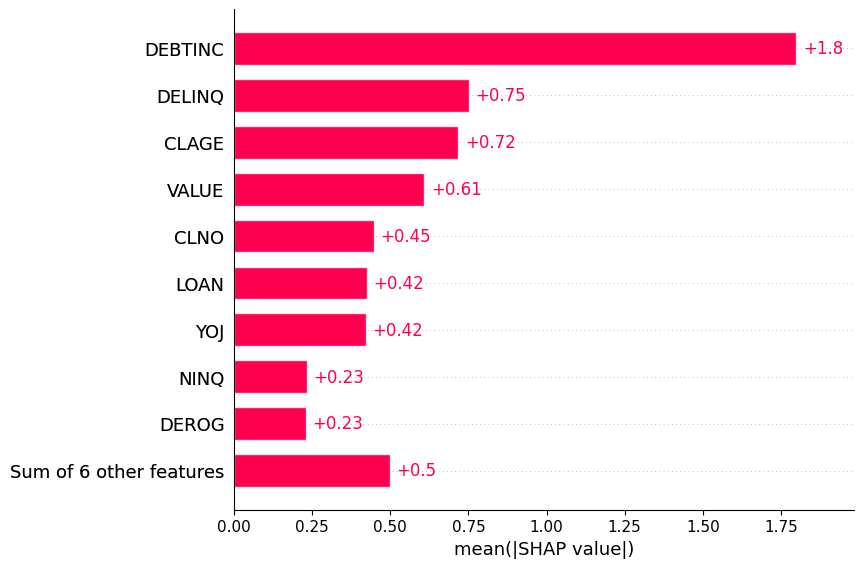

In [16]:
# La fonction suivante prends la valeur absolue de la moyenne des 
# valeurs de Shapley sur tout l'échantillon, nous donnant ainsi une vision
# globale quant à la pertinence des variables dans le modèle, mais plus sur 
# le sens de leurs impact.
shap.plots.bar(shap_values)


D'après les résultats du XGBoost et de Shapley, on peut déterminer les features les
plus importantes pour notre modèle. Il reste cependant encore à déterminer le nombre
features à sélectionner. Une possibilité qui ne répond pas parfaitement à la question
mais qui pourrait nous éclairer serait de tester l'accuracy d'un modèle simple en ajoutant
à chaque itération la variable à l'importance la plus grande.

In [17]:
# Liste des variables dans l'ordre d'importance
variables_par_importance = [
    "VALUE", "CLAGE", "LOAN", "CLNO", "YOJ", "DEBTINC", "NINQ", "DELINQ", "DEROG",
    "JOB_Other", "JOB_Office", "JOB_ProfExe", "REASON_HomeImp", "JOB_Sales", "JOB_Self"
]

# Définition d'une fonction pour lancer un modèle avec des paramètres aléatoires afin d'obtenir
# une diversité de modèle
def lancer_modele_aleatoire():

    # Paramètres aléatoires
    params = {
        'objective': 'binary:logistic',
        'max_depth': random.randint(1, 10),
        'alpha': random.uniform(0, 20), 
        'learning_rate': random.uniform(0.01, 1.0),  
        'seed': random.randint(0, 1000),
        'verbosity': 0
    }

    # Listes pour stocker les métriques
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_scores = []

    for i in range(1, len(variables_par_importance) + 1):

        best_col = variables_par_importance[:i]
        x_train_med_reduced = data_train[best_col]
        x_test_med_reduced = data_test[best_col]
        
        data_dmatrix_train_med_reduced = xgb.DMatrix(data=x_train_med_reduced, label=y_train)
        data_dmatrix_test_med_reduced = xgb.DMatrix(data=x_test_med_reduced, label=y_test)
        
        xgb_clf_med_reduced = xgb.train(params, dtrain=data_dmatrix_train_med_reduced, verbose_eval=False)
        
        y_pred_med_probs_reduced = xgb_clf_med_reduced.predict(data_dmatrix_test_med_reduced)
        
        y_pred_med_reduced = [1 if prob > 0.5 else 0 for prob in y_pred_med_probs_reduced]
        
        precision = precision_score(y_test, y_pred_med_reduced)
        recall = recall_score(y_test, y_pred_med_reduced)
        f1 = f1_score(y_test, y_pred_med_reduced)
        auc = roc_auc_score(y_test, y_pred_med_probs_reduced)
        
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        auc_scores.append(auc)

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=list(range(1, len(variables_par_importance) + 1)),
        y=auc_scores,
        mode='lines+markers',
        marker=dict(size=10, color='red'),
        line=dict(color='red'),
        name='AUC'
    ))

    fig.add_trace(go.Scatter(
        x=list(range(1, len(variables_par_importance) + 1)),
        y=precision_scores,
        mode='lines+markers',
        marker=dict(size=10, color='green'),
        line=dict(color='green'),
        name='Precision'
    ))

    fig.add_trace(go.Scatter(
        x=list(range(1, len(variables_par_importance) + 1)),
        y=recall_scores,
        mode='lines+markers',
        marker=dict(size=10, color='orange'),
        line=dict(color='orange'),
        name='Recall'
    ))

    fig.add_trace(go.Scatter(
        x=list(range(1, len(variables_par_importance) + 1)),
        y=f1_scores,
        mode='lines+markers',
        marker=dict(size=10, color='blue'),
        line=dict(color='blue'),
        name='F1-Score'
    ))

    fig.update_layout(
        title=f"Évolution des métriques \n(AUC, Precision, Recall, F1)\n"
              f" - Paramètres: max_depth={params['max_depth']}, alpha={round(params['alpha'], 2)}, "
              f"learning_rate={round(params['learning_rate'], 2)}",
        title_x=0.5, 
        title_y=0.9,
        title_font_size=14,
        xaxis_title="Nombre de variables",
        yaxis_title="Score",
        xaxis=dict(tickmode='linear'),
        template='plotly_white'
    )

   
    fig.show()

# Lancons 5 modèles
for _ in range(5):
    lancer_modele_aleatoire()


c:\Users\alexi\Desktop\Projet_Scoring_1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\alexi\Desktop\Projet_Scoring_1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\alexi\Desktop\Projet_Scoring_1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\alexi\Desktop\Projet_Scoring_1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero

Les résultats varient en fonction des paramètres et les conclusions quant au nombre de variable aussi mais on observe tout de même un comportement similaire des courbes entre 6 et 8 variables où elles commencent à se stabiliser. On peut donc sélectionner entre 6 et 8 variable pour la suite de nos modèles.

In [18]:
best_col =  ['VALUE', 'CLAGE', 'LOAN', 'CLNO', 'YOJ', 'DEBTINC', "NINQ", "DELINQ"]

x_train_med_reduced = data_train[best_col]
x_test_med_reduced = data_test[best_col]

data_dmatrix_train_med_reduced = xgb.DMatrix(data=x_train_med_reduced,label=y_train)
data_dmatrix_test_med_reduced = xgb.DMatrix(data=x_test_med_reduced,label=y_test)

In [19]:
# Entrainement du modèle
xgb_clf_med_reduced = xgb.train(params, dtrain = data_dmatrix_train_med_reduced)

In [20]:
y_pred_med_probs_reduced = xgb_clf_med_reduced.predict(data_dmatrix_test_med_reduced)
y_pred_med_reduced = [round(p) for p in y_pred_med_probs_reduced]

print(f"Le F1-Score de notre XGBoost réduit utilisant l'imputation par médiane est : {round(f1_score(y_test, y_pred_med_reduced),2)}")

Le F1-Score de notre XGBoost réduit utilisant l'imputation par médiane est : 0.59


<span style="font-size: 24px; color: darkred; text-decoration: underline;"><strong>Courbe ROC entre le modèle simple complet et le modèle simple réduit</strong></span>

In [21]:
lr_auc_med_reduced = roc_auc_score(y_test, y_pred_med_probs_reduced)

print(f'Modèle Naïf: ROC AUC={round(ns_auc, 2)}')
print(f'XGBoost | Avant Grid Search: ROC AUC={round(lr_auc_med, 2)}')
print(f'XGBoost | Avant Grid Search Reduced : ROC AUC={round(lr_auc_med_reduced, 2)}')


# Calcul des courbes ROC
lr_fpr_med_reduced, lr_tpr_med_reduced, _ = roc_curve(y_test, y_pred_med_probs_reduced)

fig = go.Figure()

fig.add_trace(go.Scatter(x=ns_fpr, y=ns_tpr, mode='lines',
                         name='No Skill',
                         line=dict(dash='dash', color='blue')))

fig.add_trace(go.Scatter(x=lr_fpr_med, y=lr_tpr_med, mode='lines',
                         name='XGBoost | Modèle Complet',
                         ))

fig.add_trace(go.Scatter(x=lr_fpr_med_reduced, y=lr_tpr_med_reduced, mode='lines',
                         name='XGBoost | Modèle Réduit',
                         ))

fig.update_layout(
    title="ROC Curve",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    legend_title="Modèles",
    template="plotly_white"
)
fig.show()

Modèle Naïf: ROC AUC=0.5
XGBoost | Avant Grid Search: ROC AUC=0.88
XGBoost | Avant Grid Search Reduced : ROC AUC=0.88


<span style="font-size: 24px; color: darkred; text-decoration: underline;"><strong>Optimisation du modèle réduit</strong></span>

In [22]:
params_grid = {
    'learning_rate': [0.01, 0.05],
    'gamma':[0, 0.01],
    'max_depth': [6, 7],
    'min_child_weight': [1, 2],
    'subsample': [0.6, 0.7,],
    'n_estimators': [400, 600],
    'colsample_bytree':[0.7, 0.8],
}
classifier = XGBClassifier()

grid_classifier_reduced = GridSearchCV(
    estimator=classifier,
    param_grid=params_grid,
    scoring='roc_auc',
    cv=stratified_kfold
)
grid_classifier_reduced.fit(x_train_med_reduced, y_train)

c:\Users\alexi\Desktop\Projet_Scoring_1\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning:

invalid value encountered in cast



GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.7, 0.8], 'gamma': [0, 0.01],
                         'learning_rate': [0.01, 0.05], 'max_depth': [6, 7],
                         'min_child_weight': [1, 2], 'n_estimators': [400, 600],
                         'subsample': [0.6, 0.7]},
             scoring='roc_auc')

In [23]:
# On récupère les meilleurs hyper-paramètres du modèle
best_parameters_reduced = grid_classifier_reduced.best_params_
best_parameters_reduced

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 600,
 'subsample': 0.7}

<span style="font-size: 24px; color: darkred; text-decoration: underline;"><strong>Courbes ROC entre le modèle réduit optimisé et le modèle complet optimisé</strong></span>

In [24]:
grid_test_preds_probs_reduced = grid_classifier_reduced.predict_proba(x_test_med_reduced)[:, 1]

grid_test_roc_auc_reduced = roc_auc_score(y_test, grid_test_preds_probs_reduced)

# Regardons visuellement la différence avant et après le GridSerchCV
best_model_reduced = grid_classifier_reduced.best_estimator_

# Calcul des scores AUC
lr_auc_best_reduced = roc_auc_score(y_test, grid_test_preds_probs_reduced)

print(f'Naïf: ROC AUC = {round(ns_auc, 2)}')
print(f'XGBoost | Après GridSearch: ROC AUC = {round(grid_test_roc_auc, 2)}')
print(f'XGBoost | Après GridSearch Reduced: ROC AUC = {round(lr_auc_best_reduced, 2)}')

# Calcul des courbes ROC
lr_fpr_best_reduced, lr_tpr_best_reduced, thresholds = roc_curve(y_test, grid_test_preds_probs_reduced)

tpr_fpr_diff = lr_tpr_best_reduced - lr_fpr_best_reduced

best_idx = np.argmax(tpr_fpr_diff)
best_threshold = thresholds[best_idx]
best_tpr = lr_tpr_best_reduced[best_idx]
best_fpr = lr_fpr_best_reduced[best_idx]

# Tracé des courbes ROC
fig = go.Figure()

# Courbe No Skill
fig.add_trace(go.Scatter(x=ns_fpr, y=ns_tpr, mode='lines',
                         name='Naïf',
                         line=dict(dash='dash', color='blue')))

# Courbe XGBoost après GridSearch
fig.add_trace(go.Scatter(x=lr_fpr_best, y=lr_tpr_best, mode='lines',
                         name='XGBoost | Modèle Complet Après GridSearch',
                         ))

# Courbe XGBoost après GridSearch Reduced
fig.add_trace(go.Scatter(x=lr_fpr_best_reduced, y=lr_tpr_best_reduced, mode='lines',
                         name='XGBoost | Modèle Réduit Après GridSearch',
                         ))

# Annotation du meilleur seuil
fig.add_trace(go.Scatter(
    x=[best_fpr],
    y=[best_tpr],
    mode='markers+text',
    name='Meilleur Seuil',
    marker=dict(color='black', size=10),
    text=[f'Threshold: {best_threshold:.2f}<br>TPR: {best_tpr:.2f}<br>FPR: {best_fpr:.2f}'],
    textposition='bottom center'
))

# Paramètres du graphique
fig.update_layout(
    title="Courbe ROC Avant et Après GridSearch",
    xaxis_title="Taux de Faux Positifs (FPR)",
    yaxis_title="Taux de Vrais Positifs (TPR)",
    legend_title="Modèles",
    template="plotly_white",
    width=1000,  # Largeur du graphique
    height=600,  # Hauteur du graphique
)

fig.show()


Naïf: ROC AUC = 0.5
XGBoost | Après GridSearch: ROC AUC = 0.96
XGBoost | Après GridSearch Reduced: ROC AUC = 0.94


In [25]:
threshold = 0.06
grid_test_preds_reduced = (grid_test_preds_probs_reduced >= best_threshold).astype(int)

grid_test_f1_reduced = f1_score(y_test, grid_test_preds_reduced)
print(f"Le F1-Score du modèle optimisé est le suivant : {round(grid_test_f1_reduced,2)} et son AUC est de : {round(grid_test_roc_auc_reduced,2)}")

Le F1-Score du modèle optimisé est le suivant : 0.75 et son AUC est de : 0.94


<span style="font-size: 24px; color: darkred; text-decoration: underline;"><strong>Matrice de confusion du modèle réduit optimisé</strong></span>

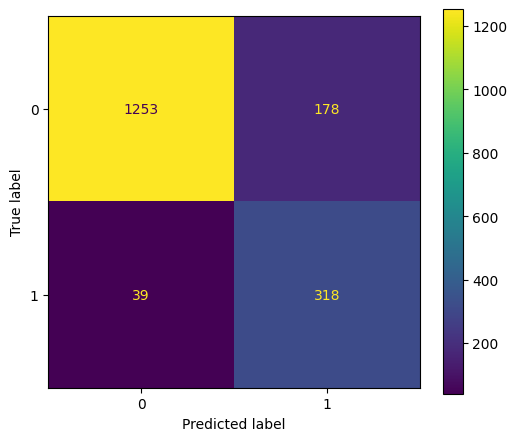

In [26]:
cm = confusion_matrix(y_test, grid_test_preds_reduced)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_classifier.classes_)
disp.plot()
plt.show()

In [27]:
# Prédictions sur l'ensemble d'entraînement
grid_train_preds_reduced = grid_classifier_reduced.predict(x_train_med_reduced)
grid_train_preds_probs_reduced = grid_classifier_reduced.predict_proba(x_train_med_reduced)[:, 1]

train_log_loss_reduced = log_loss(y_train, grid_train_preds_probs_reduced)
test_log_loss_reduced = log_loss(y_test, grid_test_preds_probs_reduced)

print(f"Train Log Loss: {train_log_loss_reduced:.2f}")
print(f"Test Log Loss: {test_log_loss_reduced:.2f}\n")

Train Log Loss: 0.03
Test Log Loss: 0.24



In [28]:
results = [y_pred_raw, grid_test_preds, grid_test_preds_reduced]
test_type = [y_test_raw, y_test, y_test]
prediction_type = ['Modèle Brute', 'Modèle Complet', 'Modèle Réduit']

gini_test_brute = np.round(2 * roc_auc_score(y_test_raw, y_pred_raw) - 1,2)
gini_test_complet = np.round(2 * roc_auc_score(y_test, grid_test_preds_probs) - 1,2)
gini_test_reduced = np.round(2 * roc_auc_score(y_test, grid_test_preds_probs_reduced) - 1,2)

metrics_brute = []
metrics_complet = []
metrics_reduced = []

for i, pred_type in enumerate(results):
    cr = classification_report(test_type[i], pred_type, output_dict=True)
    precision = np.round(cr['1']['precision'], 2)
    recall = np.round(cr['1']['recall'], 2)
    f1 = np.round(cr['1']['f1-score'], 2)
    gini = [gini_test_brute, gini_test_complet, gini_test_reduced][i]
    
    if prediction_type[i] == 'Modèle Brute':
        metrics_brute = [precision, recall, f1, gini]
    elif prediction_type[i] == 'Modèle Complet':
        metrics_complet = [precision, recall, f1, gini]
    else:
        metrics_reduced = [precision, recall, f1, gini]

metric_names = ['Precision', 'Recall', 'F1-Score', 'Indice de Gini']

df = pd.DataFrame({
    'Metric': metric_names,
    'Modèle Brute': metrics_brute,
    'Modèle Complet': metrics_complet,
    'Modèle Réduit': metrics_reduced
})

fig = go.Figure()

fig.add_trace(go.Bar(
    x=df['Metric'],
    y=df['Modèle Brute'],
    name='Modèle Brute',
    marker_color='red',
    text=df['Modèle Brute'],
    textposition='auto'
))

fig.add_trace(go.Bar(
    x=df['Metric'],
    y=df['Modèle Complet'],
    name='Modèle Complet',
    marker_color='blue',
    text=df['Modèle Complet'],
    textposition='auto'
))

fig.add_trace(go.Bar(
    x=df['Metric'],
    y=df['Modèle Réduit'],
    name='Modèle Réduit',
    marker_color='green',
    text=df['Modèle Réduit'],
    textposition='auto'
))

fig.update_layout(
    title='Comparaison des métriques entre différents modèles',
    xaxis_title='Métriques',
    yaxis_title='Valeurs',
    barmode='group', 
    template='plotly_white'
)

fig.show()
